In [54]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [2]:
# import and preview dataset

dataset = pd.read_csv("AMZN.csv")
print(dataset.head(5))

         Date      Open      High       Low     Close  Adj Close      Volume
0  1997-05-15  0.121875  0.125000  0.096354  0.097917   0.097917  1443120000
1  1997-05-16  0.098438  0.098958  0.085417  0.086458   0.086458   294000000
2  1997-05-19  0.088021  0.088542  0.081250  0.085417   0.085417   122136000
3  1997-05-20  0.086458  0.087500  0.081771  0.081771   0.081771   109344000
4  1997-05-21  0.081771  0.082292  0.068750  0.071354   0.071354   377064000


In [3]:
dataset.shape

(6516, 7)

In [4]:
# Determin datatype and the numbers
obj = (dataset.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))

int_ = (dataset.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))

fl = (dataset.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))

Categorical variables: 1
Integer variables: 0
Float variables: 5


<Axes: >

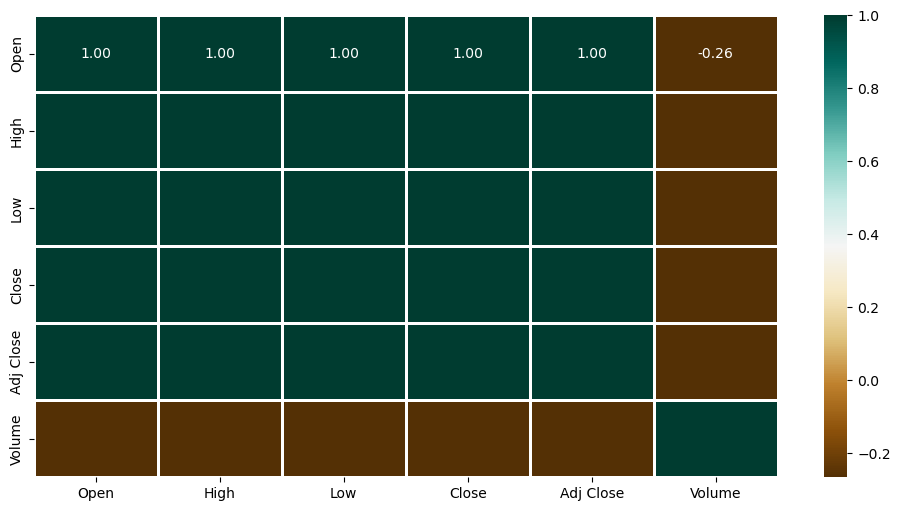

In [5]:
# Make heatmap using seaborn library

# drop date colum to create heatmap
dataset_nw = dataset.drop(columns=["Date"])
dataset_nw.head(5)

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(dataset_nw.corr(),
			cmap = 'BrBG',
			fmt = '.2f',
			linewidths = 2,
			annot = True)

C:\Users\titem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: title={'center': 'No. Unique values of Categorical Features'}>

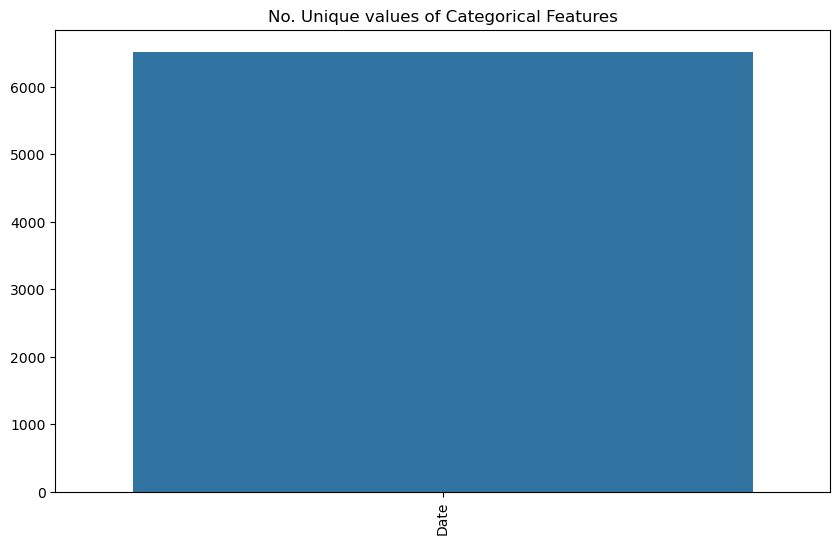

In [6]:
unique_values = []
for col in object_cols:
    unique_values.append(dataset[col].unique().size)
plt.figure(figsize=(10,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=object_cols,y=unique_values)

# No unique values in the dataset



In [7]:
# Data Cleaning
# Check for NaN values or empty values in dataset
dataset.isnull().any().any()
dataset.isnull().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [8]:
# To be double sure there is no NaN cells
dataset.isnull().sum()


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
# Convert object data to into int by using OneHotEncoder
# Collect all fueature with a loop
from sklearn.preprocessing import OneHotEncoder

s = (dataset.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of. categorical features: ', 
	len(object_cols))


Categorical variables:
['Date']
No. of. categorical features:  1


In [10]:
# Apply OneHotEncoder to the whole list
OH_encoder = OneHotEncoder(sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(dataset[object_cols]))
OH_cols.index = dataset.index
OH_cols.columns = OH_encoder.get_feature_names_out()
df_final = dataset.drop(object_cols, axis=1)
df_final = pd.concat([df_final, OH_cols], axis=1)


C:\Users\titem\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Splitting Dataset into Trainig and Testing
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X = df_final.drop(["Adj Close"], axis=1)
Y = df_final["Adj Close"]

# Split the training set into 
# training and validation set
X_train, X_valid, Y_train, Y_valid = train_test_split(
	X, Y, train_size=0.8, test_size=0.2, random_state=0)


In [ ]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_percentage_error

model_SVR = svm.SVR()
model_SVR.fit(X_train,Y_train)
Y_pred = model_SVR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred))


In [17]:
from sklearn.ensemble import RandomForestRegressor

model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
Y_pred = model_RFR.predict(X_valid)

mean_absolute_percentage_error(Y_valid, Y_pred)


0.0016586309231590756

In [18]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred = model_LR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred))


1.154428892432006e-05


In [48]:
# Predicting Stock Price with LSTM model:
# Using the "Adj Close"

df = dataset[['Adj Close']]
df.head(5)

,Adj Close
0,0.097917
1,0.086458
2,0.085417
3,0.081771
4,0.071354


In [32]:
# Get the data normalized
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [56]:
# Create look_back steps with a dataset
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

# Create dataset
look_back = 60
X, y = create_dataset(scaled_data, look_back)

In [60]:
# Reshape the data for the model
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [64]:
# Build and Train the LSTM model
# Define the model, Compile the model, Train the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


C:\Users\titem\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


162/162 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 8.6941e-04 - val_loss: 0.0014
Epoch 2/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.3403e-05 - val_loss: 0.0013
Epoch 3/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 1.6968e-05 - val_loss: 0.0013
Epoch 4/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 1.5403e-05 - val_loss: 0.0010
Epoch 5/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 1.3223e-05 - val_loss: 0.0010
Epoch 6/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 1.4398e-05 - val_loss: 8.4654e-04
Epoch 7/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 1.3159e-05 - val_loss: 8.6998e-04
Epoch 8/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 1.0643e-05 - val_loss: 7.6079e-04
Epoch 9/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.0590e-05 - val_loss: 7.6509e-04
Epoch 10/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 9.9780e-06 - val_loss: 6.9588e-04
Epoch 11/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 1.6670e-05 - val_l

In [66]:
# To make predictions
y_pred = model.predict(X_test)

# Transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [68]:
# Getting the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 16.109116366150218


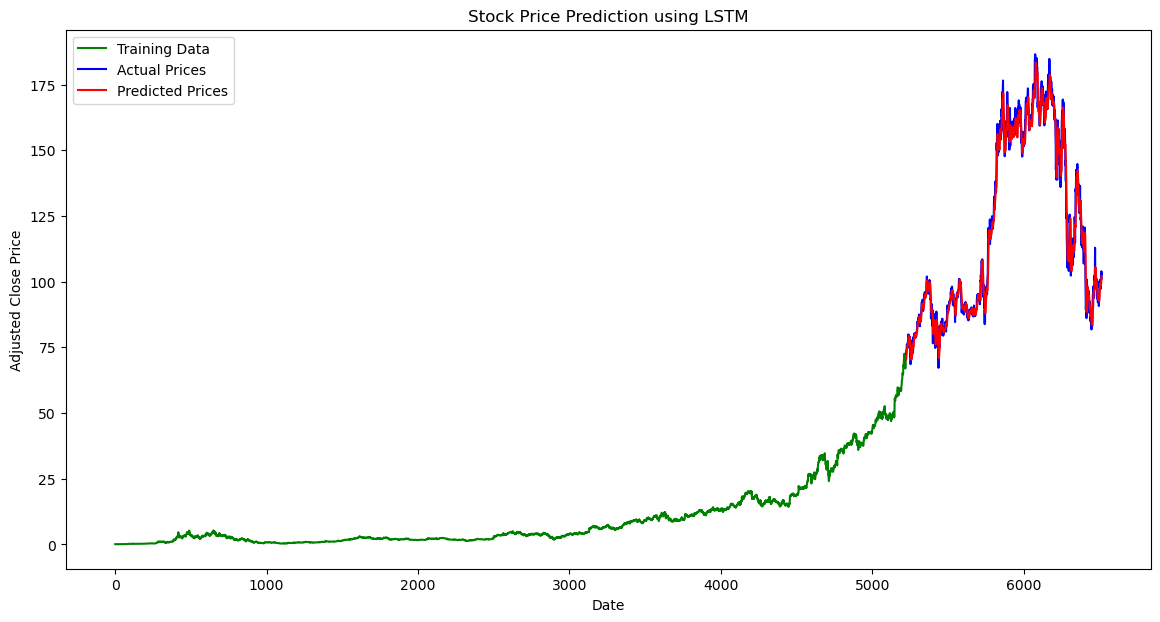

In [74]:
# Plot the Outcomes
plt.figure(figsize=(14, 7))
plt.plot(df.index[:split+look_back], scaler.inverse_transform(scaled_data[:split+look_back]), color='green', label='Training Data')
plt.plot(df.index[split+look_back:], y_test, color='blue', label='Actual Prices')
plt.plot(df.index[split+look_back:], y_pred, color='red', label='Predicted Prices')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()